# Intro

Notebook for predefining cross-validation splits.

In [2]:
from sklearn.model_selection import StratifiedKFold, PredefinedSplit
import numpy
from collections import Counter
import matplotlib.pyplot as plt
from joblib import load, dump
import pandas
from importlib import reload
from ehv import load
import seaborn
reload(load)

<module 'ehv.load' from 'd:\\dev\\active\\ehv-analysis\\ehv\\load.py'>

In [3]:
df_201 = load.remove_unwanted_features(load.load_raw_ideas("D:/Experiment_data/weizmann/EhV/201", load_labels=True))

In [4]:
df_201 = df_201.drop(columns=df_201.filter(regex=".*Intensity_MC(DAPI|TMR|Cy5|MCP).*"))
df_201_meta = df_201[["label", "replicate", "timepoint"]]
df_201 = df_201.drop(columns=["label", "replicate", "timepoint"])
df_201.shape

(150257, 134)

# Data stats

In [15]:
sel = df_201_meta["label"] != "unknown"

## timepoint

<AxesSubplot:xlabel='timepoint', ylabel='count'>

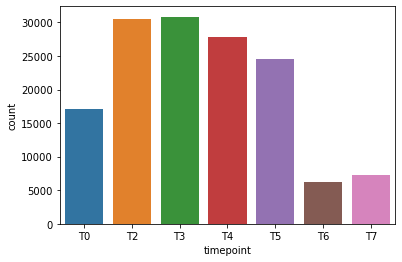

In [16]:
seaborn.countplot("timepoint", data=df_201_meta[sel])

<AxesSubplot:xlabel='timepoint', ylabel='count'>

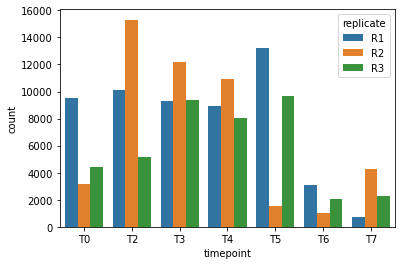

In [17]:
seaborn.countplot("timepoint", hue="replicate", data=df_201_meta[sel])

<AxesSubplot:xlabel='timepoint'>

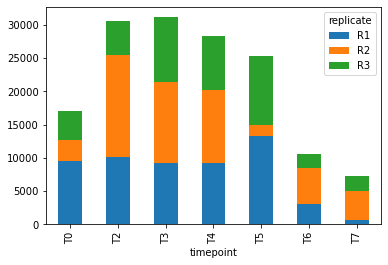

In [36]:
df_201_meta.groupby("timepoint")["replicate"].value_counts().unstack().plot.bar(stacked=True)

## replicate

<AxesSubplot:xlabel='replicate', ylabel='count'>

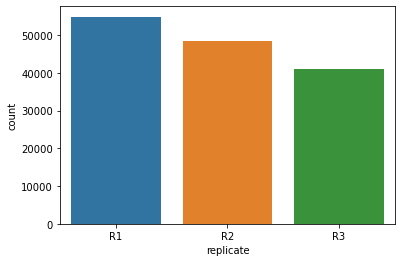

In [18]:
seaborn.countplot("replicate", data=df_201_meta[sel])

<AxesSubplot:xlabel='replicate'>

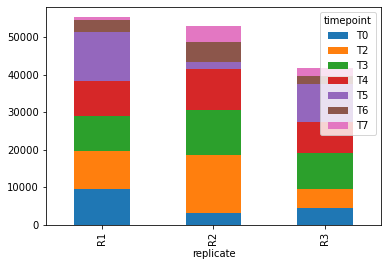

In [35]:
df_201_meta.groupby("replicate")["timepoint"].value_counts().unstack().plot.bar(stacked=True)

## label

<AxesSubplot:xlabel='label', ylabel='count'>

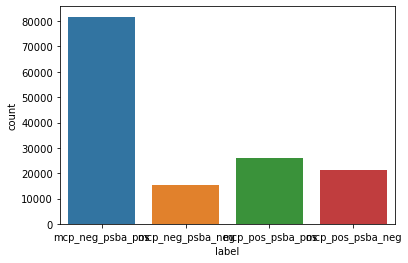

In [21]:
seaborn.countplot("label", data=df_201_meta[sel])

<AxesSubplot:xlabel='label', ylabel='count'>

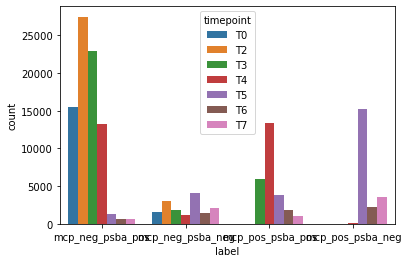

In [19]:
seaborn.countplot("label", hue="timepoint", data=df_201_meta[sel])

<AxesSubplot:xlabel='label', ylabel='count'>

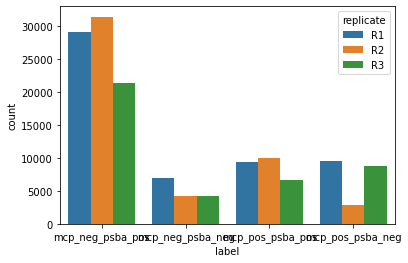

In [20]:
seaborn.countplot("label", hue="replicate", data=df_201_meta[sel])

# 3-fold replicate splits with nested 5x3-fold stratified splits wrt labels)

In [53]:
test_fold = numpy.full(shape=(len(df_201),), dtype=int, fill_value=-1)
for i, rep in enumerate(sorted(df_201_meta["replicate"].unique())):
    test_fold[(df_201_meta["replicate"] == rep).values] = i

runs = []
for i in range(5):
    nested_test_folds = []
    for train_idx, _ in PredefinedSplit(test_fold).split():
        splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        nested_test_fold = numpy.full(fill_value=-1, shape=(len(train_idx),), dtype=int)
        for i, (_, test_idx) in enumerate(splitter.split(numpy.arange(len(train_idx)), df_201_meta["label"].iloc[train_idx])):
            nested_test_fold[test_idx] = i
        nested_test_folds.append(nested_test_fold)
        
    runs.append(nested_test_folds)

# Check folds 

(0.0, 100.0)

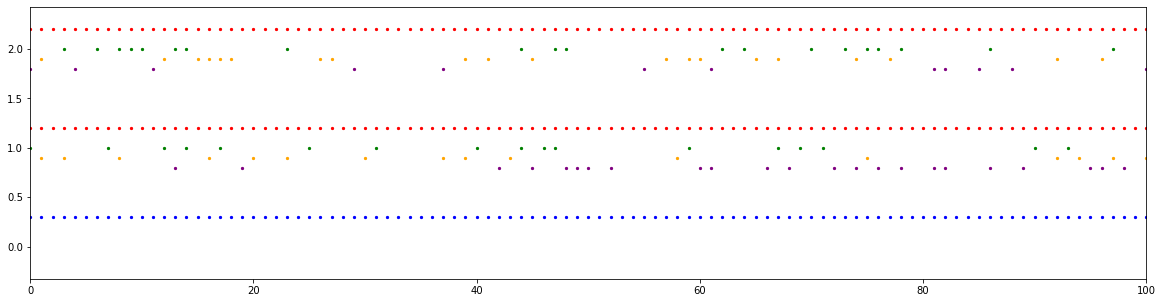

In [67]:
fig, ax = plt.subplots(figsize=(20, 5))
for i, (train_idx, test_idx) in enumerate(PredefinedSplit(test_fold).split()):
    ax.scatter(train_idx, [i+0.2]*len(train_idx), c="red", s=5)
    ax.scatter(test_idx, [i+0.3]*len(test_idx), c="blue", s=5)
    
    splitter = PredefinedSplit(runs[0][i])
    for j, ((_, test_idx), c) in enumerate(zip(splitter.split(), ["green", "orange", "purple"])):
        
        m = list(map(lambda x: train_idx[x], test_idx))
        
        ax.scatter(m, [i-j/10]*len(test_idx),c=c, s=5)
        
ax.set_xlim(0, 100)

In [60]:
dump([test_fold, subtest_folds], "D:/Experiment_data/weizmann/EhV/201/5x3_samplesplit.dat")

['D:/Experiment_data/weizmann/EhV/201/5x3_samplesplit.dat']